In [1]:
import torch
import torch.nn as nn
from dataclasses import dataclass
import torchvision
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter  
from torchvision.utils import save_image

In [242]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
device

'cuda'

In [269]:
@dataclass
class ModelArgs:
    device = 'cpu'
    batch_size = 1
    lr = 0.0002
    img_size = 128
    no_of_channels = 3
    kernel_size = (4,4)
    stride = 2
    # dropout = 0.5
    padding = 1
    lr_slope = 0.2
    beta_1 = 0.5
    beta_2 = 0.999
    no_of_kernel = 64
    lambda_gen = 10

In [243]:
ModelArgs.device = device

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  #mean = 0, std = 0.02
        
    if classname.find('Conv2D') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  #mean = 0, std = 0.02

In [315]:
class ResnetBlock(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
        )
    def forward(self, x):
        
        res = x + self.main(x)
        return res

In [316]:

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.resnet_blocks = ResnetBlock()
        
        self.down = nn.Sequential(
            
            nn.Conv2d(in_channels=ModelArgs.no_of_channels, out_channels=64, kernel_size=(7,7), stride=1, device=ModelArgs.device, padding=3),
            nn.InstanceNorm2d(num_features=64, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=2, device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=128, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=2, device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
        )
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3,3), stride=2, device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=128, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3,3), stride=2, device=ModelArgs.device, output_padding=1),
            nn.InstanceNorm2d(num_features=64, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=ModelArgs.no_of_channels, kernel_size=(7,7), stride=1, device=ModelArgs.device, padding_mode='reflect', padding=3),
            nn.InstanceNorm2d(num_features=ModelArgs.no_of_channels, device=ModelArgs.device, affine=True),
            nn.Tanh(),
            
        )
        
        
    def forward(self, x):
   
        x = self.down(x)
        x = self.resnet_blocks(x)
        x = self.up(x)
        return x

In [317]:
#Intializing the Discriminator instance
Gen = Generator().to(ModelArgs.device)
#Apply the wieght intilization function layer by layer
Gen = Gen.apply(weights_init)
#Printing the structure
print(Gen)

Generator(
  (resnet_blocks): ResnetBlock(
    (main): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU()
      (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (5): ReLU()
      (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (8): ReLU()
      (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (10): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (11): ReLU()
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [318]:
from torchinfo import summary

# images = torch.randn(64, 1, 64, 64)
# labels = torch.randint(0, 10, (64,), dtype=torch.long)
gen = Generator()
summary(model=gen,
        input_size=(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size),
        # input_data=(images.to(ModelArgs.device), labels.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Generator (Generator)                    [1, 3, 128, 128]     [1, 3, 128, 128]     --                   True
├─Sequential (down)                      [1, 3, 128, 128]     [1, 256, 31, 31]     --                   True
│    └─Conv2d (0)                        [1, 3, 128, 128]     [1, 64, 128, 128]    9,472                True
│    └─InstanceNorm2d (1)                [1, 64, 128, 128]    [1, 64, 128, 128]    128                  True
│    └─ReLU (2)                          [1, 64, 128, 128]    [1, 64, 128, 128]    --                   --
│    └─Conv2d (3)                        [1, 64, 128, 128]    [1, 128, 64, 64]     73,856               True
│    └─InstanceNorm2d (4)                [1, 128, 64, 64]     [1, 128, 64, 64]     256                  True
│    └─ReLU (5)                          [1, 128, 64, 64]     [1, 128, 64, 64]     --                   --
│    └─Conv2d (6) 

In [319]:
class PatchGAN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(ModelArgs.no_of_channels, 64, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
                
            nn.Conv2d(64, 128, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
               
            nn.Conv2d(128, 256, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
              
            nn.Conv2d(256, 512, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
            
            nn.Conv2d(512, 1, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding, padding_mode='reflect'),

            # nn.Sigmoid()
            
        )
        
    def forward(self, x):
    
        # print(x.shape)
        # print(y.shape)
        # res = torch.concat([x, y], dim=1)
        return nn.functional.sigmoid(self.main(x))
        


In [320]:
#Intializing the Discriminator instance
patchgan = PatchGAN().to(ModelArgs.device)
#Apply the wieght intilization function layer by layer
patchgan = patchgan.apply(weights_init)
#Printing the structure
print(patchgan)

PatchGAN(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  )
)


In [321]:
from torchinfo import summary

# images = torch.randn(64, 1, 64, 64)
# labels = torch.randint(0, 10, (64,), dtype=torch.long)
real_A = torch.randn(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size)
# real_B = torch.randn(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size)
patchgan = PatchGAN()
summary(model=patchgan,
        input_size=(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size),
        # input_data=(real_A),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchGAN (PatchGAN)                      [1, 3, 128, 128]     [1, 1, 14, 14]       --                   True
├─Sequential (main)                      [1, 3, 128, 128]     [1, 1, 14, 14]       --                   True
│    └─Conv2d (0)                        [1, 3, 128, 128]     [1, 64, 64, 64]      3,136                True
│    └─LeakyReLU (1)                     [1, 64, 64, 64]      [1, 64, 64, 64]      --                   --
│    └─Conv2d (2)                        [1, 64, 64, 64]      [1, 128, 32, 32]     131,200              True
│    └─InstanceNorm2d (3)                [1, 128, 32, 32]     [1, 128, 32, 32]     256                  True
│    └─LeakyReLU (4)                     [1, 128, 32, 32]     [1, 128, 32, 32]     --                   --
│    └─Conv2d (5)                        [1, 128, 32, 32]     [1, 256, 16, 16]     524,544              True
│    └─InstanceNor

In [322]:
#Config
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2


both_transform = A.Compose(
    [A.Resize(width=ModelArgs.img_size, height=ModelArgs.img_size),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        # A.HorizontalFlip(p=0.5),
        # A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        # A.ToFloat(max_value=ModelArgs.img_size),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        # A.ToFloat(max_value=ModelArgs.img_size),
        ToTensorV2(),
    ]
)

In [323]:
import numpy as np
class Cityscapes2LabelsDataset(Dataset):
    
    def __init__(self, root_dir) -> None:
        super().__init__()
        self.train_path = root_dir
        self.dir = os.listdir(self.train_path)
        
    def __len__(self):
        return len(self.dir)
    
    def __getitem__(self, index):    
        
        current_img = self.dir[index]
        img_path = os.path.join(self.train_path, current_img) 
        img = np.array(Image.open(img_path))
        input = img[:, :256, :]
        mask = img[:, 256:, :]
        augmentataions = both_transform(image = input, image0 = mask)
        input = augmentataions['image']
        mask = augmentataions['image0']
        
        input_transformed = transform_only_input(image = input)['image']
        mask_transformed = transform_only_mask(image = mask)['image']
        
        return input_transformed, mask_transformed

In [324]:
#Creating dataloaders
dir = 'data/cityscapes/train'
train = Cityscapes2LabelsDataset(dir)
trainloader = DataLoader(train, batch_size=ModelArgs.batch_size, shuffle=True)
val_dir = 'data/cityscapes/val'
val = Cityscapes2LabelsDataset(val_dir)
valloader = DataLoader(val, batch_size=ModelArgs.batch_size, shuffle=False)


In [325]:
from pathlib  import Path
save_images = Path('generated_images/')
# enc = Encoder()

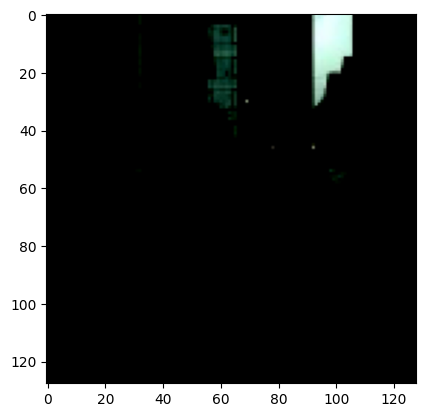

In [326]:
import matplotlib.pyplot as plt
import numpy as np

for X, y in trainloader:
    imageX = X[0]
    # imagey = y[0]

    imageX = imageX.permute(1, 2, 0).numpy()
    # imagey = imagey.permute(1, 2, 0).numpy()
    # Plot the image
    plt.imshow(imageX)
    # plt.imshow(imagey)
    plt.show()
    plt.show()
    break


In [327]:
import itertools

generatorX = Generator().to(ModelArgs.device).apply(weights_init)
discriminatorY = PatchGAN().to(ModelArgs.device).apply(weights_init)
generatorY = Generator().to(ModelArgs.device).apply(weights_init)
discriminatorX = PatchGAN().to(ModelArgs.device).apply(weights_init)


loss_fn = nn.MSELoss()  
epochs = 200 

generatorX.train()
discriminatorX.train()
generatorY.train()
discriminatorY.train()

optimizerG = torch.optim.Adam(itertools.chain(generatorX.parameters(), generatorY.parameters()), betas=(ModelArgs.beta_1, ModelArgs.beta_2), lr=ModelArgs.lr) #For discriminator
optimizerD = torch.optim.Adam(itertools.chain(discriminatorY.parameters(), discriminatorX.parameters()), betas=(ModelArgs.beta_1, ModelArgs.beta_2), lr=ModelArgs.lr) #For generator



real_label = 1
fake_label = 0


loss_g = []
loss_d = []
img_list = []


In [328]:
#Training loop

from tqdm import tqdm

iters = 0
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()
 
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")

img_counter = 0
for epoch in tqdm(range(epochs)):

    for X, y in trainloader:

    
        X = X.to(ModelArgs.device)
        y = y.to(ModelArgs.device)
        if(img_counter > 50):
            img_counter = 0
            
        
        #############################
        # Discriminator Training
        #############################
        with torch.cuda.amp.autocast():
            #Enabling the discriminators trainable ability 
            for params in discriminatorX.parameters():
                params.requires_grad = True            
                
            current_batch_size = X.shape[0]  #Getting the current batch size
            
            real_data = torch.ones((current_batch_size,), device=ModelArgs.device)

            # 1. Forward pass
            y_pred = discriminatorX(X)
            # print(y_pred)
            # print(y_pred.shape)
            # 2. Calculate  and accumulate loss
            loss_real = loss_fn(y_pred, real_data)

            # 3. Optimizer zero grad
            optimizerD.zero_grad()

        
            # loss_real.backward()


            #Train the discriminator (with fake data)

            # noise = torch.randn((batch_size, latent_vector_size, 1, 1), device=device)
            fake_data = torch.zeros(( current_batch_size,), device=ModelArgs.device)
            mask_generated_by_generatorY = generatorY(y)

            #1. Forward pass
            y_pred = discriminatorX(mask_generated_by_generatorY.detach())


            # 2. Calculate  and accumulate loss
            loss_fake = loss_fn(y_pred, fake_data)


            #Accumulating total discriminator loss
            discriminatorX_combined_loss = (loss_real + loss_fake) 
            # loss_d.append(discriminator_combined_loss.item())

            
            
            #Enabling the discriminators trainable ability 
            for params in discriminatorY.parameters():
                params.requires_grad = True            
                
            current_batch_size = X.shape[0]  #Getting the current batch size
            
            real_data = torch.ones((current_batch_size,), device=ModelArgs.device)

            # 1. Forward pass
            y_pred = discriminatorY(y)
            # print(y_pred.shape)
            
            # 2. Calculate  and accumulate loss
            loss_real = loss_fn(y_pred, real_data)


            #Train the discriminator (with fake data)

            # noise = torch.randn((batch_size, latent_vector_size, 1, 1), device=device)
            fake_data = torch.zeros(( current_batch_size,), device=ModelArgs.device)
            mask_generated_by_generatorX = generatorX(X)

            #1. Forward pass
            y_pred = discriminatorY(mask_generated_by_generatorX.detach())


            # 2. Calculate  and accumulate loss
            loss_fake = loss_fn(y_pred, fake_data)
            
            
            discriminatorY_combined_loss = (loss_real + loss_fake) 
            
            discriminator_combined_loss = (discriminatorX_combined_loss + discriminatorY_combined_loss) * 0.5
            
            
            # 4. Loss backward
            d_scaler.scale(discriminator_combined_loss).backward()
            
            # 5. Optimizer step
            d_scaler.step(optimizerD)
            d_scaler.update()
        

        ###########################
        # Generator Training
        ##########################
        with torch.cuda.amp.autocast():
            #Disabling the discriminators trainable ability 
            for params in discriminatorX.parameters():
                params.requires_grad = False
            
            #Disabling the discriminators trainable ability 
            for params in discriminatorY.parameters():
                params.requires_grad = False
                
            # mask_generated_by_generator = unet(X)
            labels = torch.ones((current_batch_size,), device=ModelArgs.device)

            #1. Forward pass
            y_pred = discriminatorX(mask_generated_by_generatorY)
            # y_pred = torch.argmax(probs, dim=1).type(torch.float32)


            #2. Calculate and accumulate loss
            loss_geny = loss_fn(y_pred,labels) 
            
    
            # mask_generated_by_generator = unet(X)
            labels = torch.ones((current_batch_size,), device=ModelArgs.device)

            #1. Forward pass
            y_pred = discriminatorY(mask_generated_by_generatorX)
            # y_pred = torch.argmax(probs, dim=1).type(torch.float32)


            #2. Calculate and accumulate loss
            loss_genx = loss_fn(y_pred,labels) 
            # print(loss_geny)
            # print(loss_genx)
            # print(nn.functional.l1_loss(mask_generated_by_generatorY, X))
            # print(nn.functional.l1_loss(mask_generated_by_generatorX, y))
            combined_generator_loss = loss_geny + loss_genx + ModelArgs.lambda_gen * (nn.functional.l1_loss(mask_generated_by_generatorY, X) + nn.functional.l1_loss(mask_generated_by_generatorX, y))

            # 3. Optimizer zero grad
            optimizerG.zero_grad()

            # 4. Loss backward
            g_scaler.scale(combined_generator_loss).backward()

            # 5. Optimizer step
            g_scaler.step(optimizerG)
            g_scaler.update()
        
        
        

        if iters % 200 == 0:
            print("Iterations: ", iters, "Epoch: ", epoch, "Generator loss: ", combined_generator_loss.item(), "Discriminator loss: ", discriminator_combined_loss.item())

    
        if iters % 200 == 0:
            
            print('saving the output')
            torchvision.utils.save_image(X* 0.5 + 0.5,'{}/realB_images_iters_{}.png'.format(save_images, iters))
            torchvision.utils.save_image(y* 0.5 + 0.5,'{}/realA_images_iters_{}.png'.format(save_images, iters))
            # fakeA = generatorX(X)
            # fakeB = generatorY(y)
            torchvision.utils.save_image(mask_generated_by_generatorX* 0.5 + 0.5,'{}/fake_imageA_iters_{}.png'.format(save_images, iters))
            torchvision.utils.save_image(mask_generated_by_generatorY* 0.5 + 0.5,'{}/fake_imageB_iters_{}.png'.format(save_images, iters))


            img_grid_fakeA = torchvision.utils.make_grid(mask_generated_by_generatorX, normalize=True)
            img_grid_fakeB = torchvision.utils.make_grid(mask_generated_by_generatorY, normalize=True)
            # img_grid_map = torchvision.utils.make_grid(X, normalize=True)
                
            writer_fake.add_image(
                        "Cityscapes2lables FakeA Images", img_grid_fakeA, global_step=iters
                    )
            writer_real.add_image(
                        "Cityscapes2lables FakeB Images", img_grid_fakeB, global_step=iters
                    )
            
            # writer_real.add_image(
            #             "Map2Aerial Aerial Images", img_grid_map, global_step=iters
            #         )
                    

            # Check pointing for every epoch
            # torch.save(generator.state_dict(), 'weights/CelebA/generator_steps_%d.pth' % (iters))
            # torch.save(discriminator.state_dict(), 'weights/CelebA/discriminator_steps_%d.pth' % (iters))


        iters += 1


  0%|          | 0/200 [00:00<?, ?it/s]/home/yuvrajsingh/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iterations:  0 Epoch:  0 Generator loss:  13.941393852233887 Discriminator loss:  0.656898021697998
saving the output
Iterations:  200 Epoch:  0 Generator loss:  7.152299880981445 Discriminator loss:  0.04200435057282448
saving the output
Iterations:  400 Epoch:  0 Generator loss:  8.328140258789062 Discriminator loss:  0.013077827170491219
saving the output
Iterations:  600 Epoch:  0 Generator loss:  7.669099807739258 Discriminator loss:  0.03464417904615402
saving the output
Iterations:  800 Epoch:  0 Generator loss:  6.395097732543945 Discriminator loss:  0.009978562593460083
saving the output
